<a href="https://colab.research.google.com/github/MustafaKhan670093/Machine-Learning-Playbook/blob/master/Cat%20and%20Dog%20Classifier%20(Transfer%20Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import torch
import numpy as np
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from google.colab import files

# **Download and Unzip The Dataset**

In [ ]:
!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip

In [ ]:
!unzip Cat_Dog_data.zip

# **Checking If GPU Is Available**

In [4]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("The ML code in this project will be trained on " + str(device))

The ML code in this project will be trained on cuda


# **Loading Data**

In [5]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.Compose([transforms.RandomRotation(30),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])



#Update the data_dir variable with the location of the dataset
data_dir = '/content/Cat_Dog_data'

# choose the training and test datasets
train_data = datasets.ImageFolder(root= data_dir + '/train', transform=transform)
test_data = datasets.ImageFolder(root=data_dir + '/test', transform=transform)


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))  #floor function rounds down a decimal value
train_idx, valid_idx = indices[split:], indices[:split]

#When creating a slice, as in [1:4], the first index number is where the slice starts (inclusive), and the second index number is where the slice ends (exclusive).
#For this reason, in [......., split, .....], [split:] results in int(split) all the way to the end of the list, while
#[:split] results in the beginning of the list till split.


# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#subsetrandom sampler samples elements randomly from a given list of indices, without replacement.


# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))


Num training images:  22500
Num test images:  2500


# **Visualize A Batch Of Training Data**

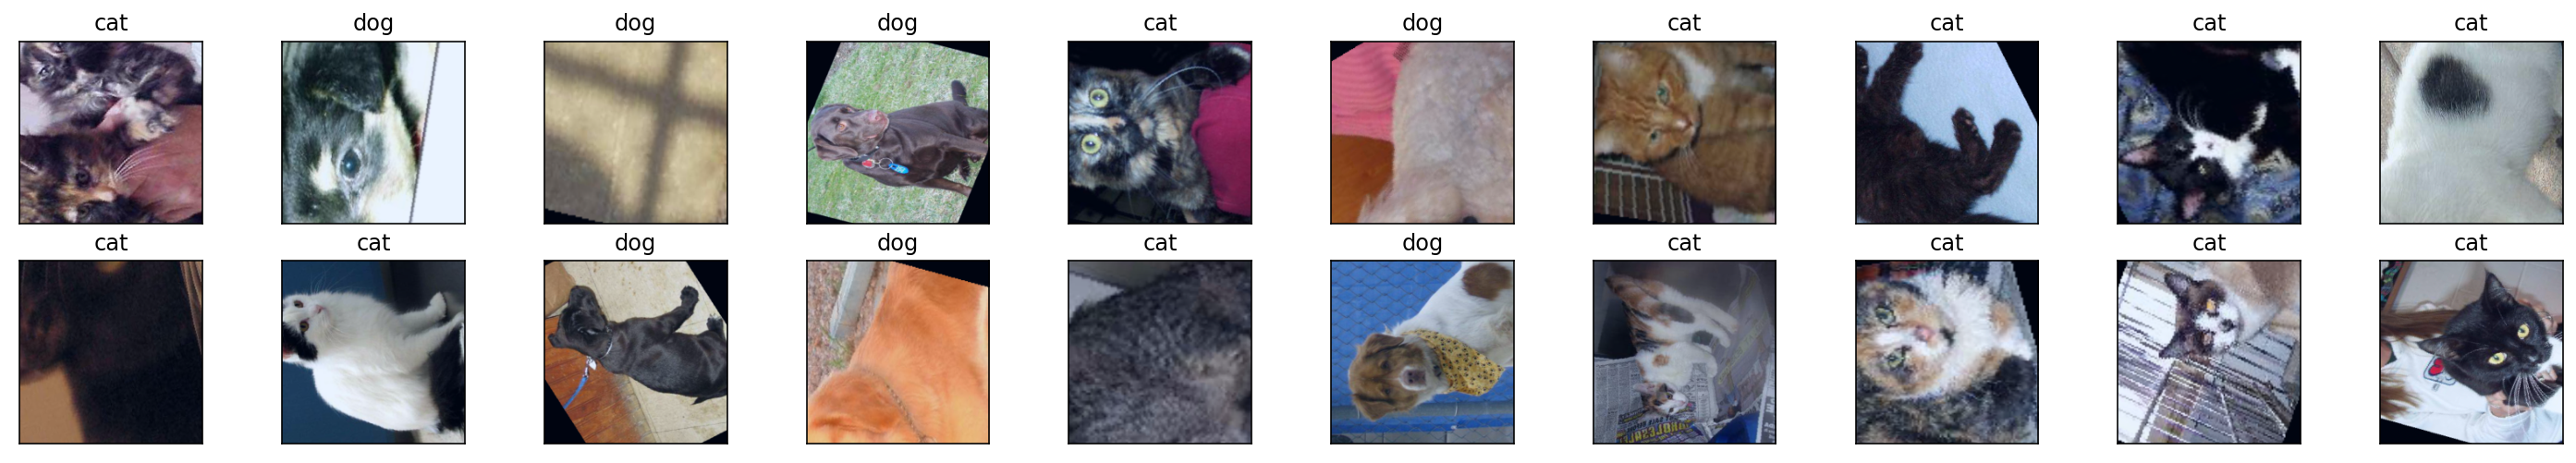

In [6]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

#The labels have been one hot encoded. 0 for cat and 1 for dog.
#The following line of code makes the labels more readable.
readable_label=[]
for label in labels:
    if label == 0:
        readable_label.append('cat')
    else:
        readable_label.append('dog')

#The following two lines of code avoid clipping input data by normalizing the images first
images -= images.min()
images /= images.max()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx]), )
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(readable_label[idx])
    
    #Note: If you wanted to use the one hot encoding labels, use the following line of code + comment out the readable_label code above.
    #ax.set_title(str(readable_label[idx].item()))

# **Defining The ML Model**

In [7]:
#The different models available can be found here: https://pytorch.org/docs/stable/torchvision/models.html.
#Simply write 'model' in the next cell to see what is within the model. This helps with understanding
#what the architecture of the pretrained model is.

#Select a model whose weights will be transfered
model = models.vgg16(pretrained=True)

# We don't need to touch the weights in the architecture. 
# We only need to change the classifier. Therefore:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

#Defining the classifier
classifier = nn.Sequential(nn.Linear(25088, 4096), 
                           nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.Linear(4096, 256),
                           nn.ReLU(), 
                           nn.Dropout(0.5),
                           nn.Linear(256, 2),               
                           nn.LogSoftmax(dim=1))


#Connecting the classifier to fully connected layer of the resnet50 architecture
model.classifier = classifier 

#Defining the loss
criterion = nn.NLLLoss()

# Defining the optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Sending model to CPU/GPU
model.to(device);

# **A More Detailed Look At The Model Architecture**

In [8]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters exist in the model.')

total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} parameters will be trained.')

#Model architecture
model

118,528,578 total parameters exist in the model.
103,813,890 parameters will be trained.


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# **Testing Speed Of GPU vs. CPU**

In [9]:
import time 

for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(train_loader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii == 3:
            break

    print(f"Device = {device}; Time per batch: {(time.time() - start) / 3:.3f} seconds")


Device = cpu; Time per batch: 11.969 seconds
Device = cuda; Time per batch: 0.004 seconds


# **Training The ML Model**

In [10]:
n_epochs = 50
epochs_no_improve = 0
n_epochs_stop = 5

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # move data and target tensors to the default device
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        #The next line of code resolved the following error: RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn
        #loss.requires_grad = True
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # move data and target tensors to the default device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'cat_and_dog_model.pth')
        valid_loss_min = valid_loss
        epochs_no_improve = 0
    
    else:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!')
            break

            # If you would like to directly download the checkpoint file, 
            #uncomment the following line of code
            #files.download('cat_and_dog_model.pth')

Epoch: 1 	Training Loss: 0.194793 	Validation Loss: 0.134291
Validation loss decreased (inf --> 0.134291).  Saving model ...
Epoch: 2 	Training Loss: 0.162119 	Validation Loss: 0.146276
Epoch: 3 	Training Loss: 0.153484 	Validation Loss: 0.134772
Epoch: 4 	Training Loss: 0.149703 	Validation Loss: 0.128069
Validation loss decreased (0.134291 --> 0.128069).  Saving model ...
Epoch: 5 	Training Loss: 0.155295 	Validation Loss: 0.123075
Validation loss decreased (0.128069 --> 0.123075).  Saving model ...
Epoch: 6 	Training Loss: 0.151487 	Validation Loss: 0.134383
Epoch: 7 	Training Loss: 0.147744 	Validation Loss: 0.127701
Epoch: 8 	Training Loss: 0.157508 	Validation Loss: 0.120595
Validation loss decreased (0.123075 --> 0.120595).  Saving model ...
Epoch: 9 	Training Loss: 0.143265 	Validation Loss: 0.132514
Epoch: 10 	Training Loss: 0.134609 	Validation Loss: 0.183873
Epoch: 11 	Training Loss: 0.139310 	Validation Loss: 0.122403
Epoch: 12 	Training Loss: 0.140363 	Validation Loss: 0.1

# **Load Model With Lowest Validation Loss**

In [14]:
#Loading trained weights into the model
state_dict = torch.load('cat_and_dog_model.pth')
model.load_state_dict(state_dict)

#Use the following line of code if you would like to see what's in the state_dict.
#print(state_dict.keys())

<All keys matched successfully>

# **Test The Trained Network**

In [15]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # move data and target tensors to the default device
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(3):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.133273

Test Accuracy of     0: 97% (1216/1250)
Test Accuracy of     1: 90% (1137/1250)
Test Accuracy of   0.0: N/A (no training examples)

Test Accuracy (Overall): 94% (2353/2500)


# **Visualize Sample Test Results**

0: [Cat] and 1: [Dog]
The value outside the brackets is the prediction. The value inside the bracket is the ground truth.


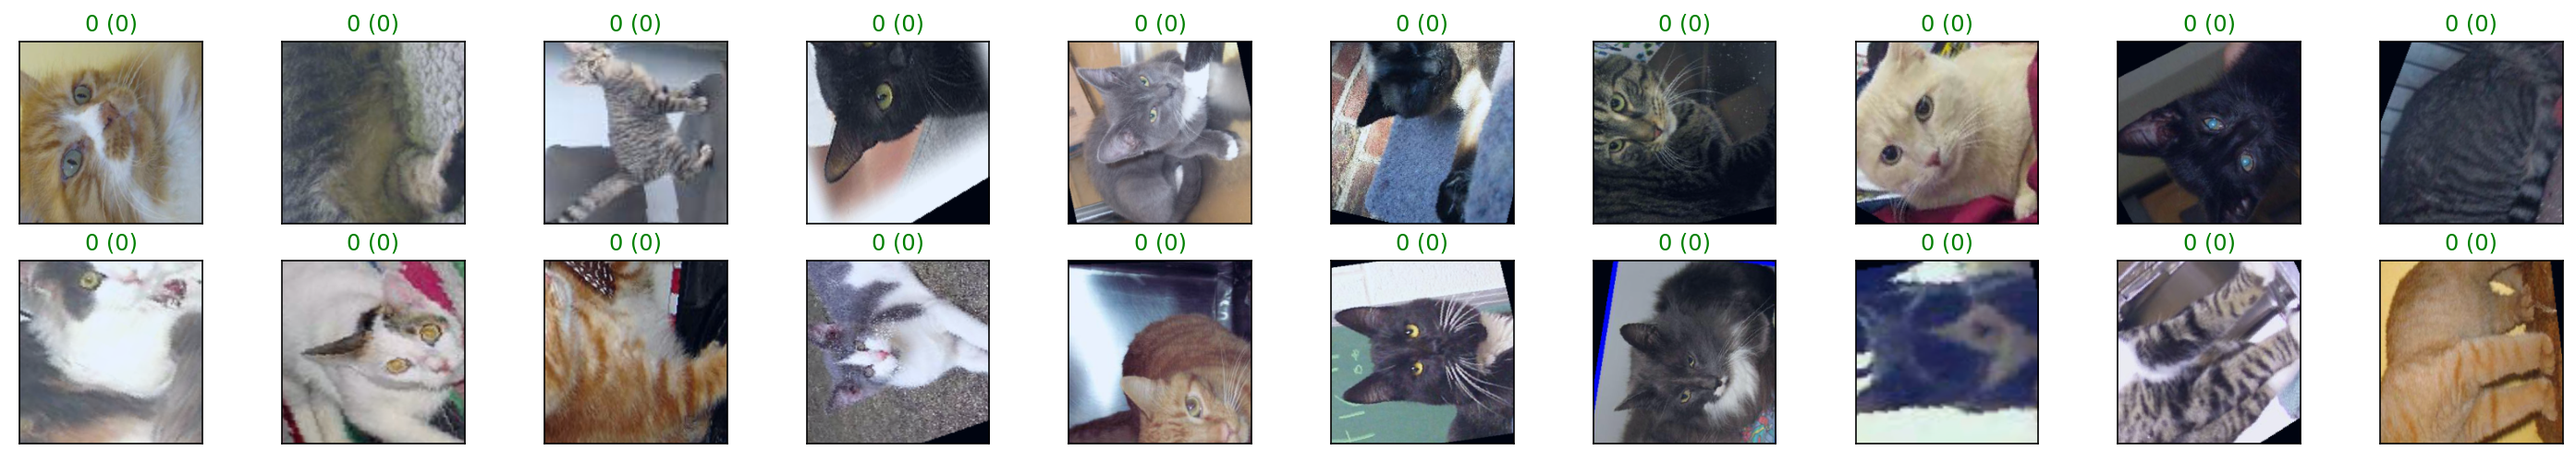

In [16]:
print("0: [Cat] and 1: [Dog]")
print("The value outside the brackets is the prediction. The value inside the bracket is the ground truth.")

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

#The following two lines of code avoid clipping input data by normalizing the images first
images -= images.min()
images /= images.max()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.cpu().data.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx]), )

    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))